In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
from linearmodels import PanelOLS
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
suicide = pd.read_csv('who_suicide_statistics.csv')
suicide.head()

,country,year,sex,age,suicides_no,population
0,Albania,1985,female,15-24 years,NaN,277900.0
1,Albania,1985,female,25-34 years,NaN,246800.0
2,Albania,1985,female,35-54 years,NaN,267500.0
3,Albania,1985,female,5-14 years,NaN,298300.0
4,Albania,1985,female,55-74 years,NaN,138700.0


In [3]:
classification = pd.read_excel('CLASS.xls')
classification = classification.drop(0)
classification.columns = ['Economy', 'income_group']
classification.head()

,Economy,income_group
1,Afghanistan,Low income
2,Albania,Upper middle income
3,Algeria,Upper middle income
4,American Samoa,Upper middle income
5,Andorra,High income


In [4]:
suicide = suicide.merge(classification, left_on='country', right_on='Economy').drop(['Economy'], axis=1)
suicide.head(10)

,country,year,sex,age,suicides_no,population,income_group
0,Albania,1985,female,15-24 years,NaN,277900.0,Upper middle income
1,Albania,1985,female,25-34 years,NaN,246800.0,Upper middle income
2,Albania,1985,female,35-54 years,NaN,267500.0,Upper middle income
3,Albania,1985,female,5-14 years,NaN,298300.0,Upper middle income
4,Albania,1985,female,55-74 years,NaN,138700.0,Upper middle income
5,Albania,1985,female,75+ years,NaN,34200.0,Upper middle income
6,Albania,1985,male,15-24 years,NaN,301400.0,Upper middle income
7,Albania,1985,male,25-34 years,NaN,264200.0,Upper middle income
8,Albania,1985,male,35-54 years,NaN,296700.0,Upper middle income
9,Albania,1985,male,5-14 years,NaN,325800.0,Upper middle income


In [5]:
unemployment = pd.read_csv('Unemployment.csv')
unemployment = pd.melt(unemployment, id_vars=['Country Name', 'Series Name'])

unemployment['sex'] = np.where(unemployment['Series Name'] == 
                               'Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate)', 
                               'male', 
                          np.where(unemployment['Series Name'] == 
                                   'Unemployment, female (% of female labor force) (modeled ILO estimate)', 'female', 
                                   np.where(unemployment['Series Name'] == 
                                            'Unemployment, male (% of male labor force) (modeled ILO estimate)', 
                                            'male','female')))

unemployment = unemployment.replace(['Unemployment, female (% of female labor force) (modeled ILO estimate)', 
                      'Unemployment, male (% of male labor force) (modeled ILO estimate)',
                      'Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate)',
                      'Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate)'],
                      ['Adult', 'Adult', 'Youth', 'Youth'])

unemployment['variable'] = unemployment['variable'].str.slice(0, 4)

unemployment.columns = ['country', 'Age', 'year', 'unemployment', 'sex']

unemployment['year'] = unemployment['year'].astype(str).astype(int)
unemployment.head()

,country,Age,year,unemployment,sex
0,Afghanistan,Youth,1991,25.31500053,male
1,Afghanistan,Youth,1991,26.88800049,female
2,Afghanistan,Adult,1991,11.61600018,male
3,Afghanistan,Adult,1991,14.56099987,female
4,Albania,Youth,1991,37.2859993,male


In [6]:
suicide['Age'] = np.where(suicide['age'] == '5-14 years', 'Youth', 
                          np.where(suicide['age'] == '15-24 years', 'Youth', 'Adult'))
suicide.head(10)

,country,year,sex,age,suicides_no,population,income_group,Age
0,Albania,1985,female,15-24 years,NaN,277900.0,Upper middle income,Youth
1,Albania,1985,female,25-34 years,NaN,246800.0,Upper middle income,Adult
2,Albania,1985,female,35-54 years,NaN,267500.0,Upper middle income,Adult
3,Albania,1985,female,5-14 years,NaN,298300.0,Upper middle income,Youth
4,Albania,1985,female,55-74 years,NaN,138700.0,Upper middle income,Adult
5,Albania,1985,female,75+ years,NaN,34200.0,Upper middle income,Adult
6,Albania,1985,male,15-24 years,NaN,301400.0,Upper middle income,Youth
7,Albania,1985,male,25-34 years,NaN,264200.0,Upper middle income,Adult
8,Albania,1985,male,35-54 years,NaN,296700.0,Upper middle income,Adult
9,Albania,1985,male,5-14 years,NaN,325800.0,Upper middle income,Youth


In [7]:
suicide = suicide.merge(unemployment, on=['country', 'Age', 'year', 'sex']).drop(['Age'], axis=1)
suicide = suicide[['country', 'income_group', 'year', 'sex', 'age', 'suicides_no', 'population', 'unemployment']]
suicide['unemployment'] = suicide['unemployment'].replace('..', np.nan)
suicide['unemployment'] = suicide['unemployment'].astype(str).astype(float)
suicide.head()

,country,income_group,year,sex,age,suicides_no,population,unemployment
0,Albania,Upper middle income,1991,female,15-24 years,NaN,301100.0,24.313
1,Albania,Upper middle income,1991,female,5-14 years,NaN,333300.0,24.313
2,Albania,Upper middle income,1991,female,25-34 years,NaN,274700.0,27.680
3,Albania,Upper middle income,1991,female,35-54 years,NaN,316500.0,27.680
4,Albania,Upper middle income,1991,female,55-74 years,NaN,160800.0,27.680


IDEA: create a linear model to predict population using each variable (except suicides_no). Use the valid entries as training data and then fill in the missing entries using the model. Then do the same thing regressing all of the variables on suicides_no to fill in the missing entries. Then conduct the overall analysis and get rid of country to avoid collinearity. Talk to Jen about panel vs cross sectional vs time series vs straight up regression. Also should I predict suicides_no with population as a feature or suicide rate, dividing suicides by population.

In [8]:
pois_pop = smf.glm('population~country+income_group+year+sex+age', data=suicide, missing='drop',
                   family=sm.families.Poisson()).fit()
pois_pop.summary()
na_pop = suicide[suicide['population'].isnull()==True]
preds = pois_pop.predict(na_pop)
na_pop['population'] = preds
suicide.update(na_pop)

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-c

In [9]:
lm_unemployment = smf.ols('unemployment~country+income_group+year+sex+age+population', data=suicide, 
                          missing='drop').fit()
lm_unemployment.rsquared
#Note the R-squared for the imputation model

0.6926290191340625

Fill missing unemployment with the model

In [10]:
na_unemployment = suicide[suicide['unemployment'].isnull()==True]
preds = lm_unemployment.predict(na_unemployment)
na_unemployment['unemployment'] = preds
suicide.update(na_unemployment)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
pois_suic = smf.glm('suicides_no~country+income_group+year+sex+age+population+unemployment', data=suicide, 
                 missing='drop', family=sm.families.Poisson()).fit()
na_suic = suicide[suicide['suicides_no'].isnull()==True]
preds = pois_suic.predict(na_suic)
na_suic['suicides_no'] = preds
suicide.update(na_suic)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [12]:
suicide['suicide_rate'] = suicide['suicides_no'] / suicide['population'] * 100
suicide.drop(['suicides_no', 'population'], axis=1, inplace=True)

Standardize the data

In [13]:
# suic_dum = pd.get_dummies(suicide, drop_first=True)
# suicide_rate = suic_dum['suicide_rate']
# suic_dum.drop('suicide_rate', axis=1, inplace=True)
# cols = suic_dum.columns
# scaler = preprocessing.StandardScaler()
# scaled_df = scaler.fit_transform(suic_dum)
# scaled_df = pd.DataFrame(scaled_df, columns=cols)
# scaled_df.columns = scaled_df.columns.str.replace(' ', '_')
# scaled_df.columns = scaled_df.columns.str.replace('-', '_')
# scaled_df.columns = scaled_df.columns.str.replace('+', '')
# scaled_df['suicide_rate'] = suicide_rate

In [14]:
suicide_temp = suicide

suicide_temp['year'] = suicide_temp['year'].astype(str)
suicide_rate = suicide_temp['suicide_rate']
scaled_df = suicide_temp.drop('suicide_rate', axis=1)

num_cols = scaled_df.columns[scaled_df.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

scaled_df['year'] = scaled_df['year'].astype(float)
scaled_df = pd.get_dummies(scaled_df, drop_first=True)

scaler = preprocessing.StandardScaler()
scaled_df[num_cols] = scaler.fit_transform(scaled_df[num_cols])

scaled_df['suicide_rate'] = suicide_rate

scaled_df.columns = scaled_df.columns.str.replace(' ', '_')
scaled_df.columns = scaled_df.columns.str.replace('-', '_')
scaled_df.columns = scaled_df.columns.str.replace('+', '')

# Model 1: Suicide Rate against Unemployment Only

In [15]:
#Worry about assumptions later
lm1 = smf.ols('suicide_rate~unemployment', data=scaled_df).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           suicide_rate   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     811.7
Date:                Thu, 28 Feb 2019   Prob (F-statistic):          7.13e-176
Time:                        20:08:17   Log-Likelihood:                 67332.
No. Observations:               26400   AIC:                        -1.347e+05
Df Residuals:                   26398   BIC:                        -1.346e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0119      0.000    102.431      0.000       0.012       0.012
unemployment    -0.0033      0.000    -28.490      0.000      -0.004      -0.003
==============================================================================
Omnibus:                    21439.931   Durbin-Watson:                   0.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           867683.933
Skew:                           3.642   Prob(JB):                         0.00
Kurtosis:                      30.125   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

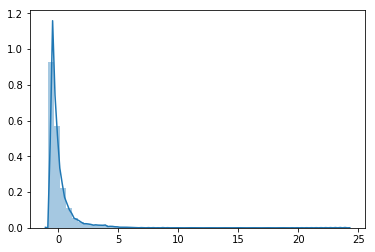

In [16]:
sns.distplot(lm1.resid_pearson)

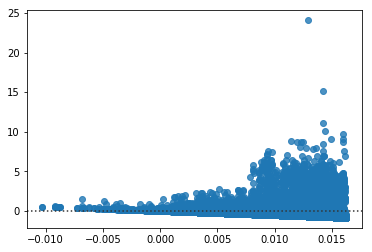

In [17]:
sns.residplot(lm1.fittedvalues, lm1.resid_pearson)

In [18]:
sms.het_breuschpagan(lm1.resid_pearson, lm1.model.exog)

(66.51215967088966,
 3.477418594331947e-16,
 66.67510212237116,
 3.3431494585490715e-16)

Text(0.5, 1.0, 'Suicide Rate vs. Unemployment by Income Group')

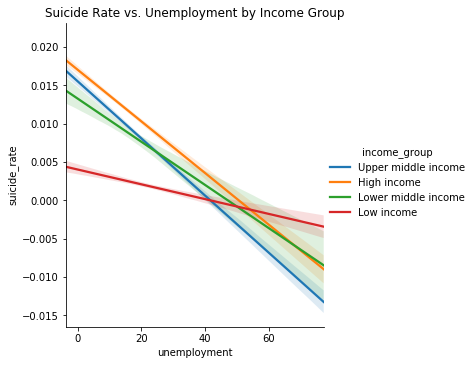

In [19]:
sns.lmplot(x = 'unemployment', y = 'suicide_rate', hue = "income_group", data = suicide, scatter=False)
plt.title('Suicide Rate vs. Unemployment by Income Group')

# Model 2: Suicide Rate against everything except country

Getting all the explanatory variables we want in our model

In [20]:
countries = [col for col in scaled_df if col.startswith('country')]
scaled_df_no_country = scaled_df.drop(countries, axis=1)
suicide_rate = scaled_df['suicide_rate']
scaled_df_no_country.drop('suicide_rate', axis=1, inplace=True)
explan_vars = "+".join(scaled_df_no_country.columns)
scaled_df_no_country['suicide_rate'] = suicide_rate

In [21]:
#Worry about assumptions later
lm2 = smf.ols('suicide_rate~' + explan_vars, data=scaled_df_no_country).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           suicide_rate   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     854.8
Date:                Thu, 28 Feb 2019   Prob (F-statistic):               0.00
Time:                        20:08:29   Log-Likelihood:                 70955.
No. Observations:               26400   AIC:                        -1.419e+05
Df Residuals:                   26388   BIC:                        -1.418e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.4813      0.029     16.648      0.000       0.425       0.538
year                                -0.0002   1.44e-05    -16.559      0.000      -0.000      -0.000
unemployment                         0.0005      0.000      4.019      0.000       0.000       0.001
income_group_Low_income             -0.0114      0.001    -13.950      0.000      -0.013      -0.010
income_group_Lower_middle_income    -0.0033      0.000     -8.731      0.000      -0.004      -0.003
income_group_Upper_middle_income    -0.0027      0.000    -12.193      0.000      -0.003      -0.002
sex_male                             0.0141      0.000     68.942      0.000       0.014       0.015
age_25_34_years                      0.0033      0.000      8.808      0.000       0.003       0.004
age_35_54_years                      0.0058      0.000     15.433      0.000       0.005       0.007
age_5_14_years                      -0.0081      0.000    -22.991      0.000      -0.009      -0.007
age_55_74_years                      0.0068      0.000     18.030      0.000       0.006       0.007
age_75_years                         0.0135      0.000     36.156      0.000       0.013       0.014
==============================================================================
Omnibus:                    21017.543   Durbin-Watson:                   0.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1292683.332
Skew:                           3.367   Prob(JB):                         0.00
Kurtosis:                      36.613   Cond. No.                     5.71e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
lm2.conf_int()

,0,1
Intercept,0.424621,0.537947
year,-0.000267,-0.000211
unemployment,0.000248,0.000719
income_group_Low_income,-0.012999,-0.009796
income_group_Lower_middle_income,-0.003996,-0.002531
income_group_Upper_middle_income,-0.003149,-0.002277
sex_male,0.013739,0.014543
age_25_34_years,0.002564,0.004032
age_35_54_years,0.005044,0.006512
age_5_14_years,-0.008760,-0.007384


# Model 3: Fixed Effects

In [23]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects

Make country and year indeces and scale the data again.

In [24]:
suicide_temp = suicide

suicide_temp['year'] = suicide_temp['year'].astype(str)
suicide_rate = suicide_temp['suicide_rate']
fixed_df = suicide_temp.drop('suicide_rate', axis=1)

num_cols = fixed_df.columns[fixed_df.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

fixed_df = pd.get_dummies(fixed_df, columns=['income_group', 'sex', 'age'], drop_first=True)

scaler = preprocessing.StandardScaler()
fixed_df[num_cols] = scaler.fit_transform(fixed_df[num_cols])

fixed_df['suicide_rate'] = suicide_rate

fixed_df['year'] = fixed_df['year'].astype(float)

fixed_df = fixed_df.set_index(['country', 'year'])

In [25]:
exog_vars = fixed_df.columns.tolist()
exog_vars.remove('suicide_rate')
exog = sm.add_constant(fixed_df[exog_vars])

Just trying out random effects model to compare it with output for fixed effects.

In [26]:
mod = RandomEffects(fixed_df['suicide_rate'], exog).fit()
mod.summary

Dep. Variable:,suicide_rate,R-squared:,0.3308
Estimator:,RandomEffects,R-squared (Between):,0.0187
No. Observations:,26400,R-squared (Within):,0.3318
Date:,"Thu, Feb 28 2019",R-squared (Overall):,0.2479
Time:,20:08:38,Log-likelihood,7.603e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1304.7
Entities:,110,P-value,0.0000
Avg Obs:,240.00,Distribution:,"F(10,26389)"
Min Obs:,12.000,,
Max Obs:,312.00,F-statistic (robust):,1305.4


Model with time effects and fixed effects but not using income group as a covariate

In [27]:
mod2 = PanelOLS(fixed_df['suicide_rate'], exog[['const', 'unemployment', 'sex_male', 
                                                'age_25-34 years', 'age_35-54 years', 'age_5-14 years', 
                                                'age_55-74 years', 'age_75+ years']], 
                entity_effects=True, time_effects=True).fit()
mod2.summary
#suicide.head()

Dep. Variable:,suicide_rate,R-squared:,0.3337
Estimator:,PanelOLS,R-squared (Between):,-0.0401
No. Observations:,26400,R-squared (Within):,0.3318
Date:,"Thu, Feb 28 2019",R-squared (Overall):,0.2418
Time:,20:09:40,Log-likelihood,7.621e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1878.8
Entities:,110,P-value,0.0000
Avg Obs:,240.00,Distribution:,"F(7,26258)"
Min Obs:,12.000,,
Max Obs:,312.00,F-statistic (robust):,1878.8


Model with time effects but no fixed effect for country. Including income group again.

In [28]:
mod3 = PanelOLS(fixed_df['suicide_rate'], exog, time_effects=True).fit()
mod3.summary
#suicide.head()

Dep. Variable:,suicide_rate,R-squared:,0.2573
Estimator:,PanelOLS,R-squared (Between):,0.0211
No. Observations:,26400,R-squared (Within):,0.3298
Date:,"Thu, Feb 28 2019",R-squared (Overall):,0.2550
Time:,20:10:46,Log-likelihood,7.097e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,913.48
Entities:,110,P-value,0.0000
Avg Obs:,240.00,Distribution:,"F(10,26364)"
Min Obs:,12.000,,
Max Obs:,312.00,F-statistic (robust):,913.48


# Model 4: Interaction between unemployment and income_group

In [29]:
lm4 = smf.ols('suicide_rate~unemployment*income_group_Upper_middle_income+unemployment*income_group_Lower_middle_income+unemployment*income_group_Low_income', data=scaled_df).fit()
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           suicide_rate   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     142.9
Date:                Thu, 28 Feb 2019   Prob (F-statistic):          1.13e-207
Time:                        20:10:52   Log-Likelihood:                 67423.
No. Observations:               26400   AIC:                        -1.348e+05
Df Residuals:                   26392   BIC:                        -1.348e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         0.0130      0.000     83.846      0.000       0.013       0.013
unemployment                                     -0.0031      0.000    -17.944      0.000      -0.003      -0.003
income_group_Upper_middle_income                 -0.0019      0.000     -7.636      0.000      -0.002      -0.001
unemployment:income_group_Upper_middle_income    -0.0003      0.000     -1.363      0.173      -0.001       0.000
income_group_Lower_middle_income                 -0.0031      0.000     -7.218      0.000      -0.004      -0.002
unemployment:income_group_Lower_middle_income     0.0005      0.001      0.919      0.358      -0.001       0.002
income_group_Low_income                          -0.0101      0.001    -10.190      0.000      -0.012      -0.008
unemployment:income_group_Low_income              0.0022      0.001      2.299      0.022       0.000       0.004
==============================================================================
Omnibus:                    21517.279   Durbin-Watson:                   0.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           895307.924
Skew:                           3.652   Prob(JB):                         0.00
Kurtosis:                      30.578   Cond. No.                         11.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
lm4.conf_int()

,0,1
Intercept,0.012681,0.013288
unemployment,-0.003427,-0.002752
income_group_Upper_middle_income,-0.002437,-0.001442
unemployment:income_group_Upper_middle_income,-0.000801,0.000144
income_group_Lower_middle_income,-0.003938,-0.002256
unemployment:income_group_Lower_middle_income,-0.000574,0.001588
income_group_Low_income,-0.012062,-0.008170
unemployment:income_group_Low_income,0.000325,0.004084
